In [1]:
!pip install nengo

In [2]:
import nengo
import numpy as np
import scipy.spatial as space

model = nengo.Network(label="Difference Target Propagation")

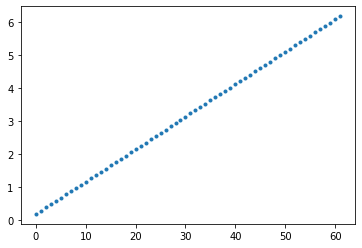

In [3]:
x_step = np.arange(np.pi/16, 2 * np.pi, np.pi/32)   # time seriese
import matplotlib.pyplot as plt
plt.plot(x_step, '.')

In [4]:
def inpfunc(x):
    return np.cos(x)/2  # [-0.5:0.5]

[0.19634954 0.49039264]
[0.29452431 0.47847017]
[0.39269908 0.46193977]


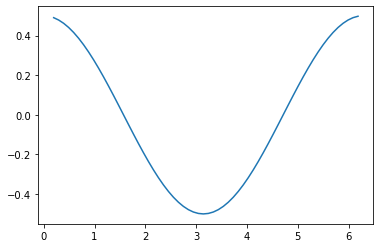

In [5]:
feature_vectors = np.transpose(np.asarray([x_step,inpfunc(x_step)]))
print(feature_vectors[0])   # [input, label]
print(feature_vectors[1])
print(feature_vectors[2])
plt.plot(x_step, inpfunc(x_step))

In [6]:
# model characteristics
step = len(x_step)
curstep = 0
n_neurons = 300
n_dim = 1

In [16]:
#Computes the DTP loss function
def DTP_loss_hidden(f):
    epsilon = (np.random.rand(1,1) - 0.5)/4
    return f + epsilon

def cycleinput(x, period, dt=0.01):
    step = int(round(period/dt))
    def stimulus(t):
        i = int(round((t-dt)/dt))
        return x[int((i/step)%len(x))]
    return stimulus

In [20]:
time = (np.pi) * 2
timedelta = time/(float(len(x_step)) * 3)

with model:
    inputstim = nengo.Node(output=cycleinput(np.transpose([inpfunc(x_step), x_step]),timedelta))
    # input function: [time_t, cos(t)]

    # Set up layers
    # input(x) -> hidden_1 -> hidden_2 -> output(y)
    in_x = nengo.Ensemble(n_neurons,n_dim)
    h_1 = nengo.Ensemble(n_neurons,n_dim)
    h_2 = nengo.Ensemble(n_neurons,n_dim)
    in_y = nengo.Ensemble(n_neurons,n_dim)

    #Set up the hidden layer and the target ensemble for the first hidden layer
    # hidden_1 -> h_loss <- traget(-1)
    hLoss = nengo.Ensemble(n_neurons,n_dim)
    target = nengo.Ensemble(n_neurons,n_dim)
    target_con = nengo.Connection(target, hLoss, transform=-1)
    nengo.Connection(h_1, hLoss)

    #Do the same for the second layer
    target2 = nengo.Ensemble(n_neurons,n_dim)
    target_h_con2 = nengo.Connection(h_2,target2,learning_rule_type = nengo.PES(1e-3))

    #Do the same for the third layer
    gLoss2 = nengo.Ensemble(n_neurons,n_dim)


    dist = nengo.Node(output = lambda t,x: np.abs(x[0] - x[1]) + np.abs(x[2] - x[3]), size_in = 4, size_out = 1)
    nengo.Connection(in_y, dist[0])
    nengo.Connection(in_x, dist[1])
    nengo.Connection(h_1, dist[2])
    nengo.Connection(h_2, dist[3])

    nengo.Connection(in_y, gLoss2)
    nengo.Connection(h_1, gLoss2, transform=-1)
    nengo.Connection(h_2, gLoss2, transform=-1)
    nengo.Connection(h_2, gLoss2)
    nengo.Connection(gLoss2, target_h_con2.learning_rule)

    learning_s1 = nengo.Node(output=lambda t: -int((t <= time/12) ))
    learning_s2 = nengo.Node(output=lambda t: -int((t <= time/2) ))
    learning_s3 = nengo.Node(output=lambda t: -int(t<= (2 * time/3)))

    nengo.Connection(learning_s1, target2.neurons, transform =[[10]]*n_neurons, synapse=None)
    nengo.Connection(learning_s2, target.neurons, transform =[[10]]*n_neurons, synapse=None)
    #Don't enable inverse loss until we swap directions
    nengo.Connection(learning_s3, hLoss.neurons,  transform =[[10]]*n_neurons, synapse=None)

    inhib_gloss = nengo.Node(output= lambda t,x: int((t <= time/2)) * x, size_in=1, size_out = 1)
    nengo.Connection(learning_s1, inhib_gloss)
    nengo.Connection(inhib_gloss,gLoss2.neurons,transform=[[10]]*n_neurons)


    inhib = nengo.Node(output= lambda t,x: int((t >= time/2)) * x, size_in=1, size_out = 1)
    nengo.Connection(h_2, inhib)
    nengo.Connection(inhib,target2)

    inhib2 = nengo.Node(output= lambda t,x: int((t >= (2 * time/3))) * x, size_in=1, size_out = 1)
    nengo.Connection(h_1, inhib2)
    nengo.Connection(inhib2,target)

    inhib3 = nengo.Node(output= lambda t,x: int(t <= (2* time/3)) * x, size_in=1, size_out = 1)
    nengo.Connection(inputstim[0], inhib3)
    nengo.Connection(inhib3,in_x, function = DTP_loss_hidden)

    inhib4 = nengo.Node(output= lambda t,x: int(t >= (2*time/3)) * x, size_in=1, size_out = 1)
    nengo.Connection(inputstim[0], inhib4)
    nengo.Connection(inhib4,in_y, function = DTP_loss_hidden)

    inhib5 = nengo.Node(output= lambda t,x: int(t >= time/2) * int(t <= (2*time/3)) * x, size_in=1, size_out = 1)
    nengo.Connection(h_1, inhib5)
    nengo.Connection(h_2, inhib5, transform = -1)
    nengo.Connection(target2, inhib5)
    nengo.Connection(inhib5,target)


    #Flip directions at the time 2/3rd mark
    inhib6 = nengo.Node(output= lambda t,x: int(t >= (2 * time/3)) * x, size_in=1, size_out = 1)
    nengo.Connection(h_2, inhib6)
    nengo.Connection(inhib6,h_1)

    inhib7 = nengo.Node(output= lambda t,x: int(t >= (2 * time/3)) * x, size_in=1, size_out = 1)
    nengo.Connection(in_y, inhib7)
    nengo.Connection(inhib7,h_2)

    inhib8 = nengo.Node(output= lambda t,x: int(t >= (2 * time/3)) * x, size_in=1, size_out = 1)
    nengo.Connection(h_1, inhib8)
    nengo.Connection(inhib8,in_x)

    inhib9 = nengo.Node(output= lambda t,x: int(t <= (2 * time/3)) * x, size_in=1, size_out = 1)
    nengo.Connection(in_x, inhib9)
    nengo.Connection(inhib9,h_1)

    inhib10 = nengo.Node(output= lambda t,x: int(t <= (2 * time/3)) * x, size_in=1, size_out = 1)
    nengo.Connection(h_1, inhib10)
    nengo.Connection(inhib10,h_2)

    inhib11 = nengo.Node(output= lambda t,x: int(t <= (2 * time/3)) * x, size_in=1, size_out = 1)
    nengo.Connection(h_2, inhib11)
    nengo.Connection(inhib11,in_y)

    probe_h1 = nengo.Probe(h_1, 'decoded_output', synapse=0.1)
    probe_h2 = nengo.Probe(h_2, 'decoded_output', synapse=0.1)
    probe_target = nengo.Probe(target, 'decoded_output', synapse = 0.1)
    probe_target2 = nengo.Probe(target2, 'decoded_output', synapse = 0.1)

    probe_x = nengo.Probe(in_x,  synapse=0.1)
    probe_y = nengo.Probe(in_y, 'decoded_output', synapse=0.1)


    probe_err2 = nengo.Probe(hLoss, synapse=0.1)
    probe_err3 = nengo.Probe(gLoss2, synapse=0.1)
    probe_err4 = nengo.Probe(dist, synapse=0.1)

    probe_stim = nengo.Probe(inputstim[0], synapse=0.1)

In [21]:
with nengo.Simulator(model, dt = 0.005) as sim:
    sim.run(time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

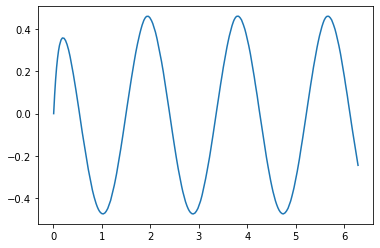

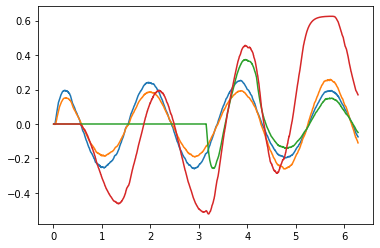

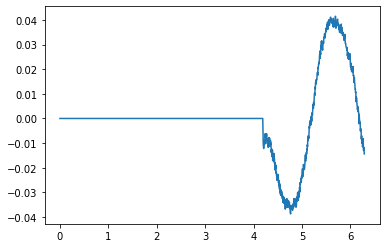

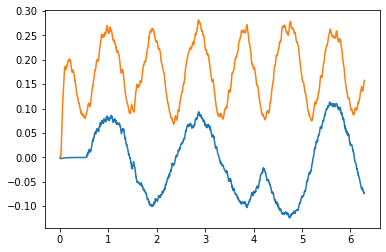

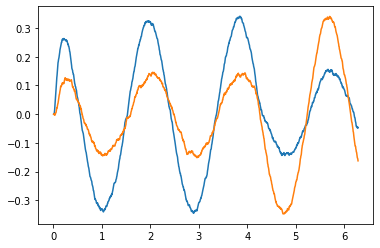

In [22]:
plt.plot(sim.trange(), sim.data[probe_stim])
plt.figure()
#First diagram is targets and hidden layers
plt.plot(sim.trange(), sim.data[probe_h1])
plt.plot(sim.trange(), sim.data[probe_h2])
plt.plot(sim.trange(), sim.data[probe_target])
plt.plot(sim.trange(), sim.data[probe_target2])
plt.figure()
#Second diagram is error signals of the first hidden layer
#plt.plot(sim.trange(), sim.data[probe_err1])
plt.plot(sim.trange(), sim.data[probe_err2])
plt.figure()
#Error signals of the second hidden layer
plt.plot(sim.trange(), sim.data[probe_err3])
plt.plot(sim.trange(), sim.data[probe_err4])
plt.figure()
#Input and output
plt.plot(sim.trange(), sim.data[probe_x])
plt.plot(sim.trange(), sim.data[probe_y])
plt.show()